In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

import pickle
import os 
# import torch

# import classifiers 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#classification report 
from sklearn.metrics import classification_report




In [20]:
#read each pickle file in the folds folder 
predicted_dict = {}
actual_dict = {}
for file in os.listdir('./folds/'):
    number = int(file[-5:-4])
    if file[:3] == 'act':
        with open('./folds/' + file, 'rb') as f:
            actual_dict[number] = pickle.load(f)
    else:
        with open('./folds/' + file, 'rb') as f:
            predicted_dict[number] = pickle.load(f)


In [21]:
# read info.csv
info = pd.read_csv('./data/info.csv')
info.columns

Index(['labels', 'frame_id', 'rotation_id', 'variant_id', 'room_amount',
       'window_amount', 'surface', 'total_exterior_wall_amount',
       'total_source_energy_consumption_GJ',
       'total_site_energy_consumption_GJ',
       'total_source_energy_consumption_per_surface_MJm2',
       'total_site_energy_consumption_per_surface_MJm2', 'energy_class',
       'site_energy_heating_GJ', 'site_energy_cooling_GJ',
       'site_energy_heating_per_surface_MJm2',
       'site_energy_cooling_per_surface_MJm2', 'total_window_amount',
       'total_wall_area_m2', 'wall_area_north_m2', 'wall_area_east_m2',
       'wall_area_south_m2', 'wall_area_west_m2',
       'total_window_opening_area_m2', 'window_opening_area_north_m2',
       'window_opening_area_east_m2', 'window_opening_area_south_m2',
       'window_opening_area_west_m2', 'total_window_wall_ratio_percent',
       'window_wall_ratio_north_percent', 'window_wall_ratio_east_percent',
       'window_wall_ratio_south_percent', 'window_wall

In [22]:

# for every element in the column 
for i in range(len(info)):
    # convert the string to a list of ints
    elem = [int(j) for j in info['labels'][i][1:-1].split(',')]
    # replace the string with the list of ints
    info['labels'][i] = elem

assert all([len(info['labels'][i]) == info['room_amount'][i] + info['window_amount'][i] for i in range(len(info))])


# Count occurrences of each label value in each row
labels_counts = info['labels'].apply(lambda x: pd.Series(x).value_counts()).fillna(0)

# Rename columns to include prefix
labels_counts.columns = ['label_count_' + str(c) for c in labels_counts.columns]

# Concatenate counts with original dataframe
info_encoded = pd.concat([info.drop('labels', axis=1), labels_counts], axis=1)

labels = ["window_xxs_n", "window_xxs_ne", "window_xxs_e", "window_xxs_se", "window_xxs_s", "window_xxs_sw", "window_xxs_w", "window_xxs_nw", "window_xs_n", "window_xs_ne", "window_xs_e", "window_xs_se", "window_xs_s", "window_xs_sw", "window_xs_w", "window_xs_nw", "window_s_n", "window_s_ne", "window_s_e", "window_s_se", "window_s_s", "window_s_sw", "window_s_w", "window_s_nw", "window_m_n", "window_m_ne", "window_m_e", "window_m_se", "window_m_s", "window_m_sw", "window_m_w", "window_m_nw", "window_l_n", "window_l_ne", "window_l_e", "window_l_se", "window_l_s", "window_l_sw", "window_l_w", "window_l_nw", "window_xl_n", "window_xl_ne", "window_xl_e", "window_xl_se", "window_xl_s", "window_xl_sw", "window_xl_w", "window_xl_nw", "window_xxl_n", "window_xxl_ne", "window_xxl_e", "window_xxl_se", "window_xxl_s", "window_xxl_sw", "window_xxl_w", "window_xxl_nw", "livingroom_xxs", "livingroom_xs", "livingroom_s", "livingroom_m", "livingroom_l", "livingroom_xl", "livingroom_xxl", "utility_xxs", "utility_xs", "utility_s", "utility_m", "utility_l", "utility_xl", "utility_xxl", "toilet_xxs", "toilet_xs", "toilet_s", "toilet_m", "toilet_l", "toilet_xl", "toilet_xxl", "bedroom_xxs", "bedroom_xs", "bedroom_s", "bedroom_m", "bedroom_l", "bedroom_xl", "bedroom_xxl", "bathroom_xxs", "bathroom_xs", "bathroom_s", "bathroom_m", "bathroom_l", "bathroom_xl", "bathroom_xxl"]


new_names = {
    f'label_count_{i}': label 
    for i, label in enumerate(labels)
}

info_encoded = info_encoded.rename(columns=new_names)


/tmp/ipykernel_709592/1070997479.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info['labels'][i] = elem


In [23]:
info_encoded

,frame_id,rotation_id,variant_id,room_amount,window_amount,surface,total_exterior_wall_amount,total_source_energy_consumption_GJ,total_site_energy_consumption_GJ,total_source_energy_consumption_per_surface_MJm2,...,window_xxs_sw,window_xxs_se,window_m_ne,toilet_xxs,utility_xxl,toilet_l,livingroom_xl,window_l_ne,toilet_s,toilet_m
0,0,0,0,5,2,61.4342,9.0,133.36,38.66,2170.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,5,9,61.4342,9.0,169.73,51.10,2762.72,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,2,5,2,61.4342,9.0,137.23,39.83,2233.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,3,5,7,61.4342,9.0,157.81,47.55,2568.84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,5,9,61.4342,9.0,169.15,51.52,2753.29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,1499,2,3,7,11,82.0921,11.0,202.12,60.22,2462.09,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
23996,1499,3,0,7,8,82.0921,11.0,183.11,53.89,2230.56,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
23997,1499,3,1,7,8,82.0921,11.0,201.27,60.81,2451.77,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
23998,1499,3,2,7,11,82.0921,11.0,201.87,59.76,2459.01,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Split the data into training and testing sets
test_set = info_encoded[:int(len(info_encoded)*0.2)]
train_set = info_encoded[int(len(info_encoded)*0.2):]

In [25]:
input_cols = ["window_xxs_n", "window_xxs_ne", "window_xxs_e", "window_xxs_se", "window_xxs_s", "window_xxs_sw", "window_xxs_w", "window_xxs_nw", "window_xs_n", "window_xs_ne", "window_xs_e", "window_xs_se", "window_xs_s", "window_xs_sw", "window_xs_w", "window_xs_nw", "window_s_n", "window_s_ne", "window_s_e", "window_s_se", "window_s_s", "window_s_sw", "window_s_w", "window_s_nw", "window_m_n", "window_m_ne", "window_m_e", "window_m_se", "window_m_s", "window_m_sw", "window_m_w", "window_m_nw", "window_l_n", "window_l_ne", "window_l_e", "window_l_se", "window_l_s", "window_l_sw", "window_l_w", "window_l_nw", "window_xl_n", "window_xl_ne", "window_xl_e", "window_xl_se", "window_xl_s", "window_xl_sw", "window_xl_w", "window_xl_nw", "window_xxl_n", "window_xxl_ne", "window_xxl_e", "window_xxl_se", "window_xxl_s", "window_xxl_sw", "window_xxl_w", "window_xxl_nw", "livingroom_xxs", "livingroom_xs", "livingroom_s", "livingroom_m", "livingroom_l", "livingroom_xl", "livingroom_xxl", "utility_xxs", "utility_xs", "utility_s", "utility_m", "utility_l", "utility_xl", "utility_xxl", "toilet_xxs", "toilet_xs", "toilet_s", "toilet_m", "toilet_l", "toilet_xl", "toilet_xxl", "bedroom_xxs", "bedroom_xs", "bedroom_s", "bedroom_m", "bedroom_l", "bedroom_xl", "bedroom_xxl", "bathroom_xxs", "bathroom_xs", "bathroom_s", "bathroom_m", "bathroom_l", "bathroom_xl", "bathroom_xxl"]
output_col = 'energy_class'

In [26]:
train_set

,frame_id,rotation_id,variant_id,room_amount,window_amount,surface,total_exterior_wall_amount,total_source_energy_consumption_GJ,total_site_energy_consumption_GJ,total_source_energy_consumption_per_surface_MJm2,...,window_xxs_sw,window_xxs_se,window_m_ne,toilet_xxs,utility_xxl,toilet_l,livingroom_xl,window_l_ne,toilet_s,toilet_m
4800,300,0,0,8,3,87.4888,12.0,174.00,50.14,1988.78,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4801,300,0,1,8,12,87.4888,12.0,214.27,63.38,2449.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4802,300,0,2,8,3,87.4888,12.0,176.91,50.99,2022.14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4803,300,0,3,8,9,87.4888,12.0,205.11,61.21,2344.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4804,300,1,0,8,12,87.4888,12.0,213.97,63.79,2445.72,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,1499,2,3,7,11,82.0921,11.0,202.12,60.22,2462.09,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
23996,1499,3,0,7,8,82.0921,11.0,183.11,53.89,2230.56,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
23997,1499,3,1,7,8,82.0921,11.0,201.27,60.81,2451.77,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
23998,1499,3,2,7,11,82.0921,11.0,201.87,59.76,2459.01,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Define the list of classifiers to test
classifiers = [
    RandomForestClassifier(n_estimators=200, random_state=42),
    GradientBoostingClassifier(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    SVC(),
    LogisticRegression(max_iter=1000),
    MLPClassifier(),
]

In [29]:
# Loop over classifiers
metrics = {}
for classifier in classifiers:
    print(f"Running k-fold cross-validation for classifier: {type(classifier).__name__}")
    # Train and evaluate the classifier using k-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_accuracies = []
    fold_cms = []
    fold_crs = []
    for train_index, test_index in kf.split(train_set):
        # Split data into training and validation sets
        train_data = train_set.iloc[train_index]
        val_data = train_set.iloc[test_index]

        # Train the classifier on the training set
        classifier.fit(train_data[input_cols], train_data[output_col])

        # Evaluate the classifier on the validation set
        predictions = classifier.predict(val_data[input_cols])

        # Calculate accuracy and confusion matrix
        accuracy = accuracy_score(val_data[output_col], predictions)
        cm = confusion_matrix(val_data[output_col], predictions)
        cr = classification_report(val_data[output_col], predictions)

        # Add accuracy and confusion matrix to lists for this fold
        fold_accuracies.append(accuracy)
        fold_cms.append(cm)
        fold_crs.append(cr)

    metrics[type(classifier).__name__] = [fold_accuracies, fold_cms, fold_crs]

Running k-fold cross-validation for classifier: RandomForestClassifier
Running k-fold cross-validation for classifier: GradientBoostingClassifier
Running k-fold cross-validation for classifier: DecisionTreeClassifier
Running k-fold cross-validation for classifier: KNeighborsClassifier
Running k-fold cross-validation for classifier: SVC
Running k-fold cross-validation for classifier: LogisticRegression
Running k-fold cross-validation for classifier: MLPClassifier


/home/gianmarco/.conda/envs/advo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gianmarco/.conda/envs/advo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gianmarco/.conda/envs/advo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gianmarco/.conda/envs/advo/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

In [30]:
#dump metrics
with open('metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

In [ ]:
#load metrics pickle
with open('metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)


In [31]:
fold_accuracies = []
fold_cms = []
fold_crs = []
for fold in range(10):
    truth = actual_dict[fold]
    pred = predicted_dict[fold]

    # Calculate accuracy and confusion matrix
    accuracy = accuracy_score(truth, pred)
    cm = confusion_matrix(truth, pred)  
    cr = classification_report(truth, pred)

    # Add accuracy and confusion matrix to lists for this fold
    fold_accuracies.append(accuracy)
    fold_cms.append(cm)
    fold_crs.append(cr)

class DGLClassifier:
    def __init__(self):
        pass

classifiers.append(DGLClassifier())
metrics[type(DGLClassifier()).__name__] = [fold_accuracies, fold_cms, fold_crs]

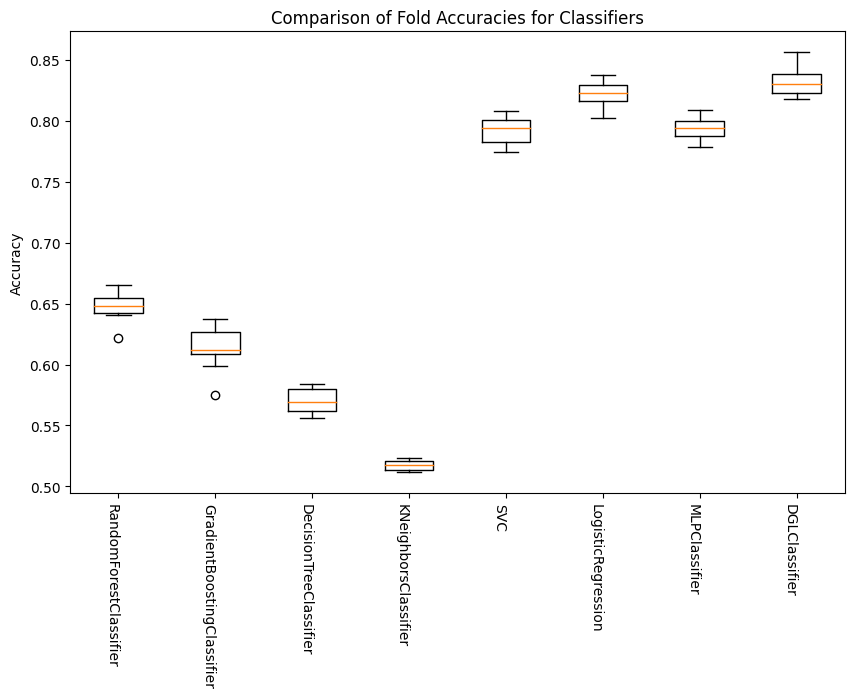

In [32]:
import matplotlib.pyplot as plt

# Extract fold accuracies for each classifier
classifiers_accs = {}
for classifier, metrics_list in metrics.items():
    accuracies_list = metrics_list[0]
    classifiers_accs[classifier] = accuracies_list

# Create boxplots
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(classifiers_accs.values())
ax.set_xticklabels(classifiers_accs.keys(), rotation=-90, ha='right')
ax.set_title('Comparison of Fold Accuracies for Classifiers')
ax.set_ylabel('Accuracy')
plt.show()


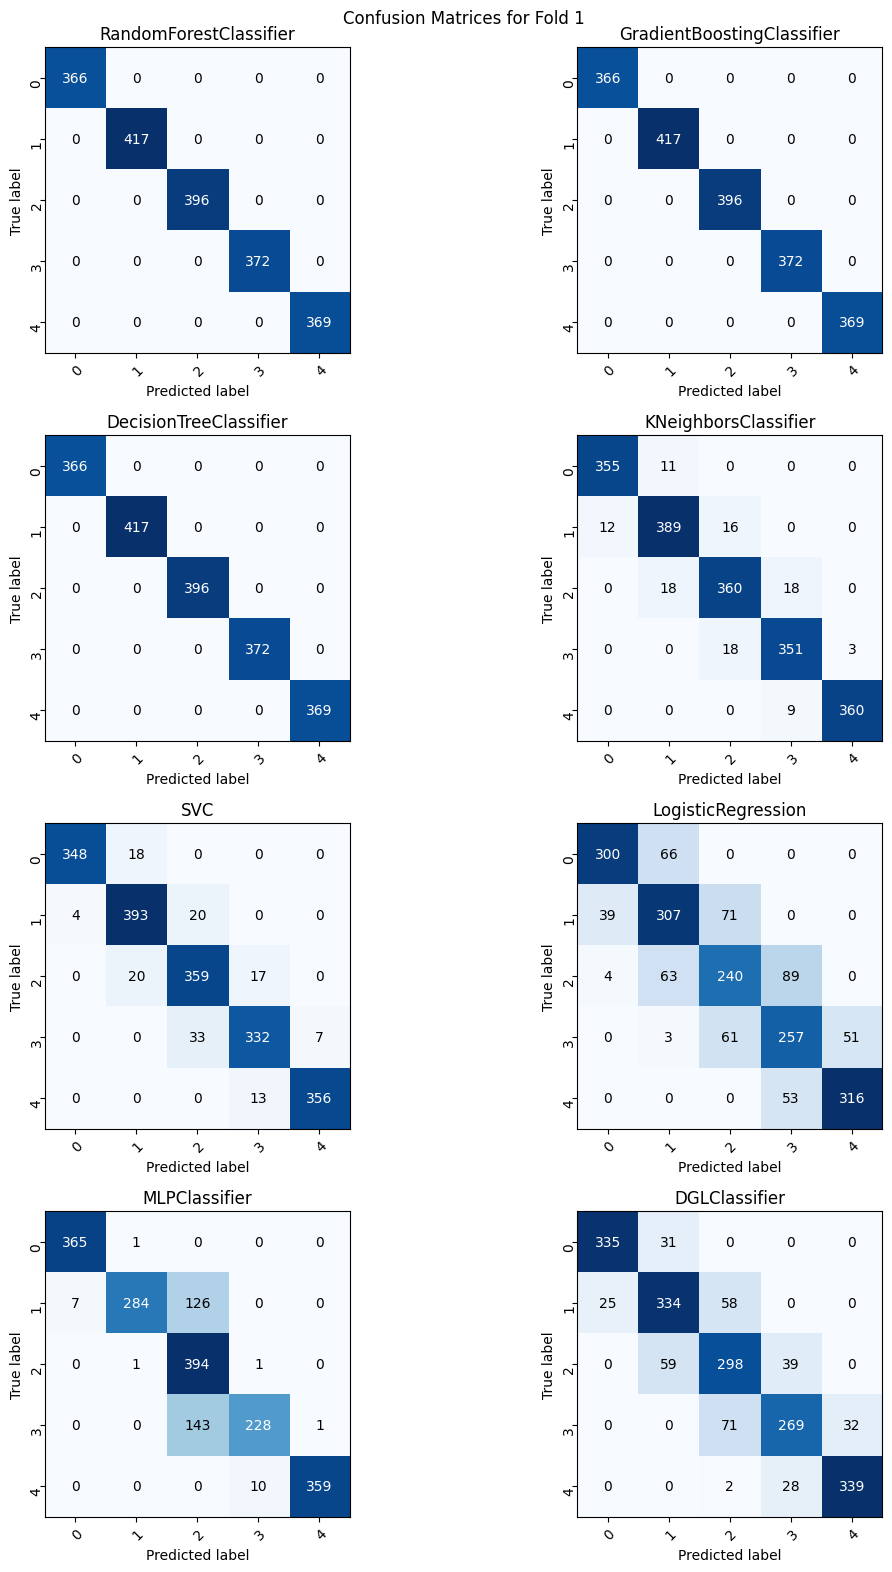

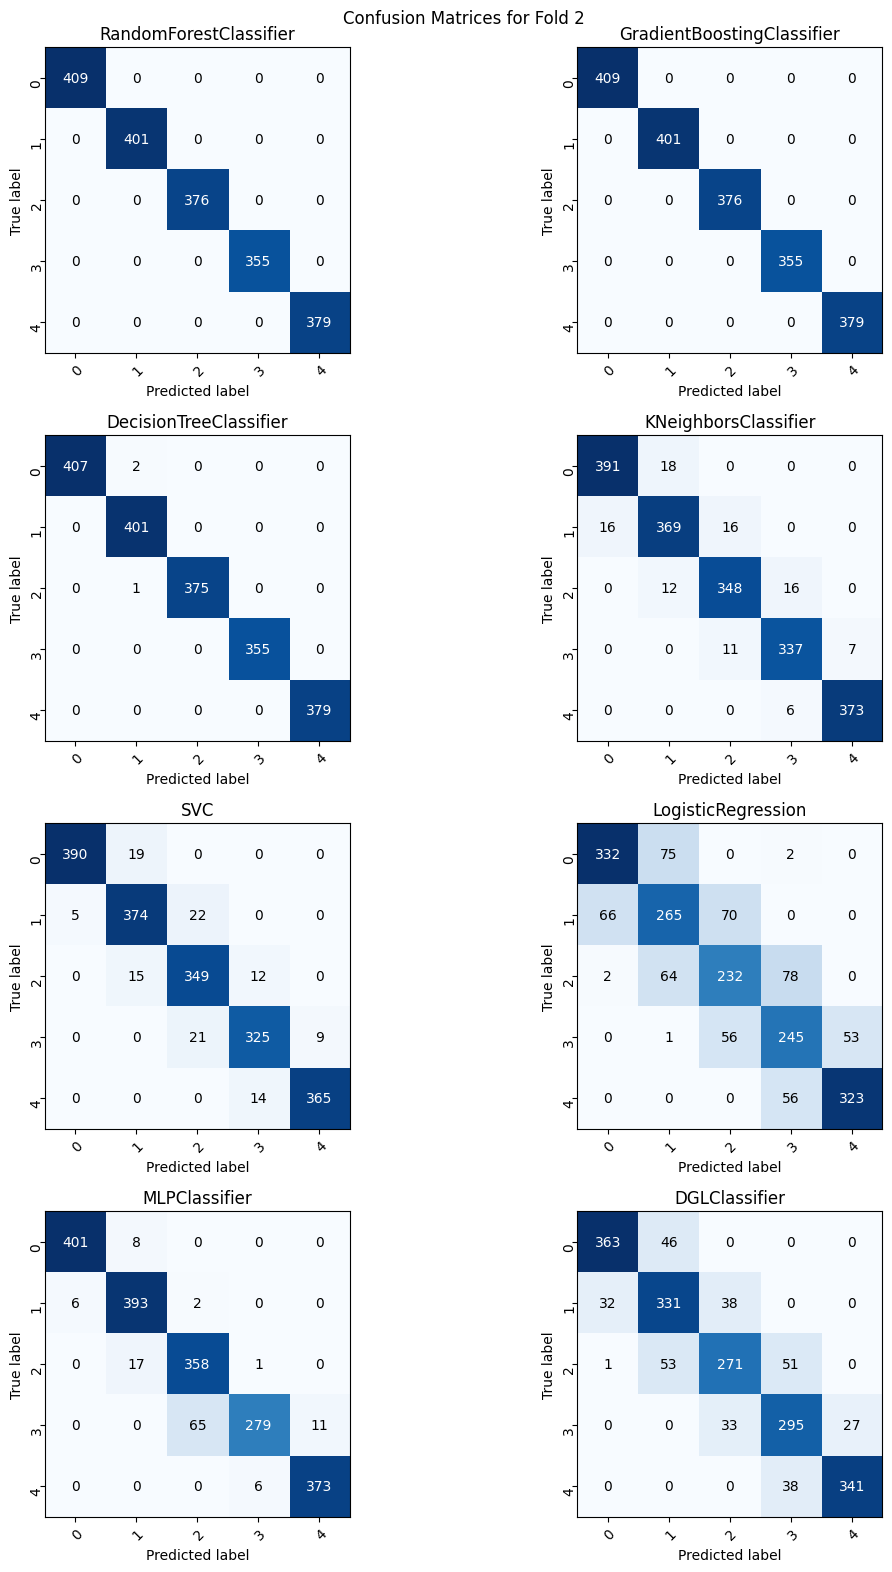

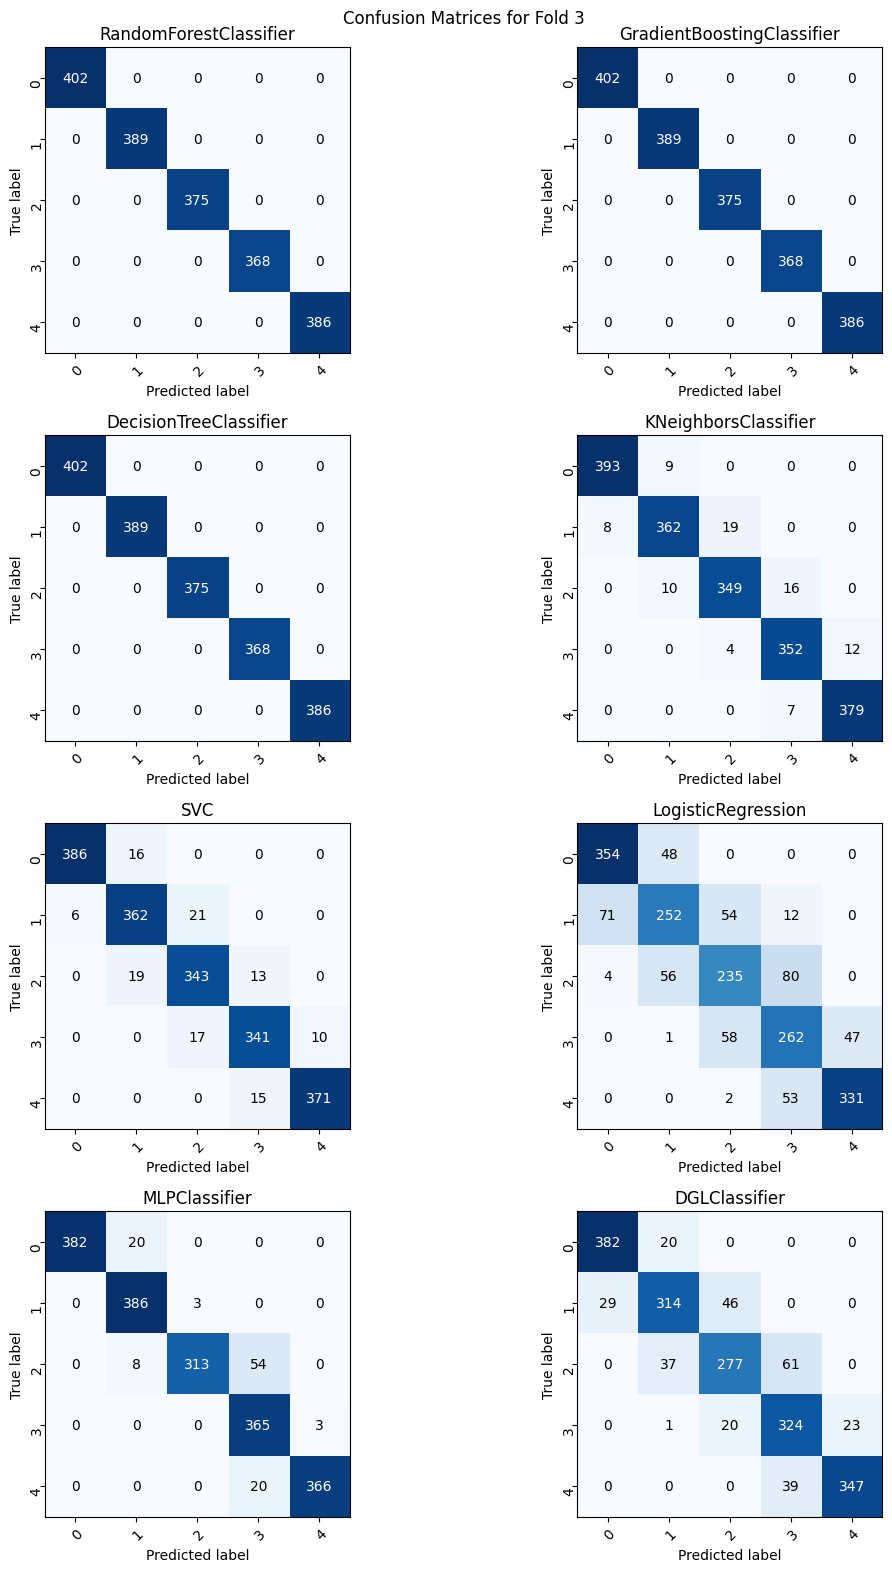

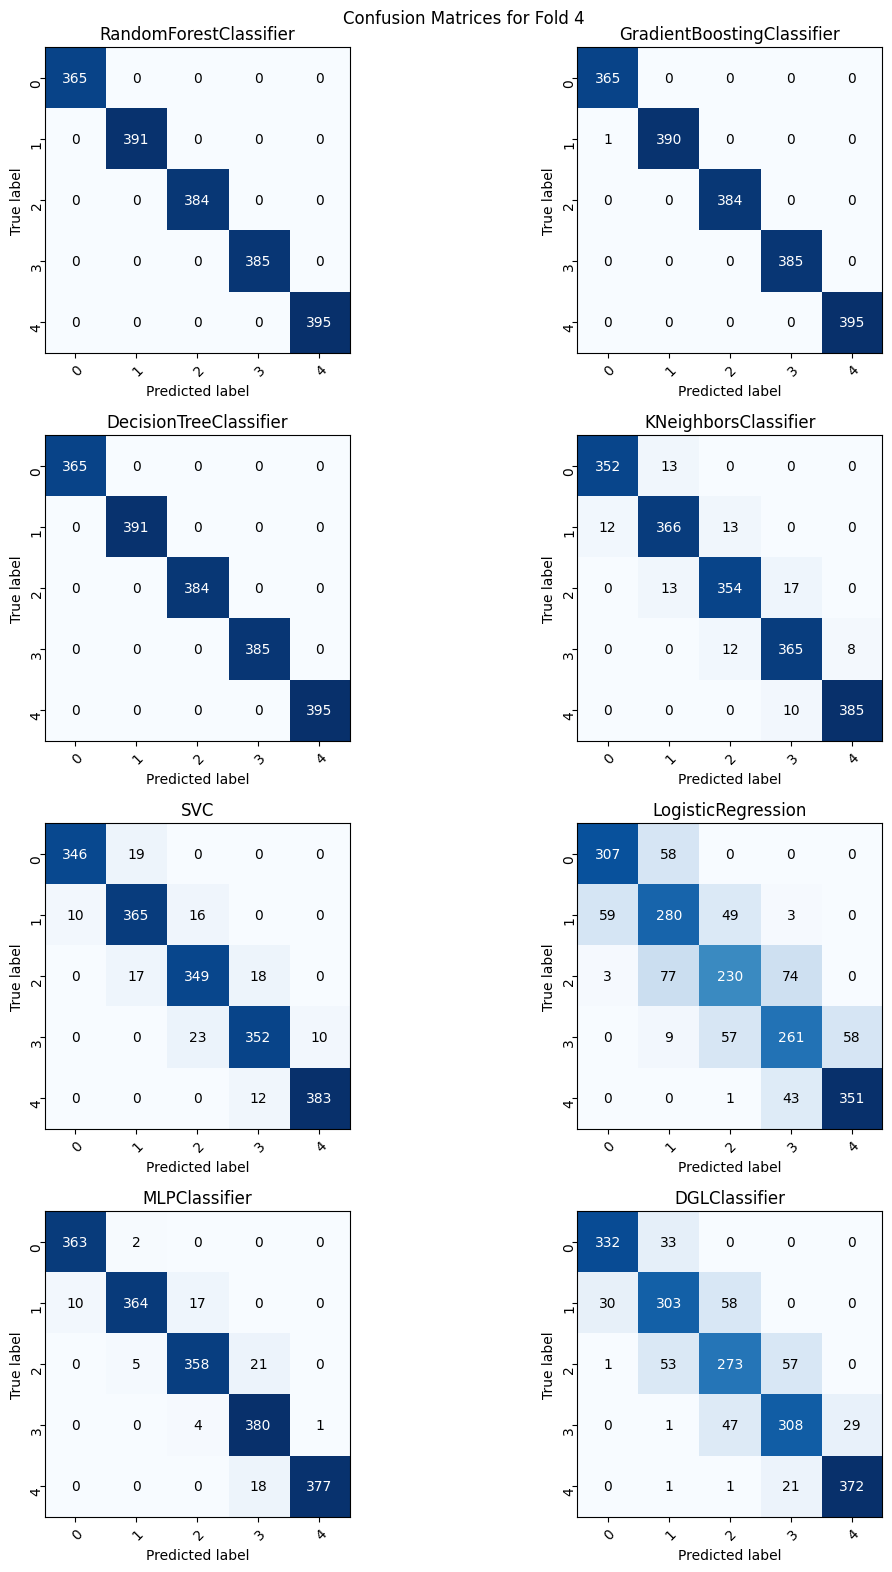

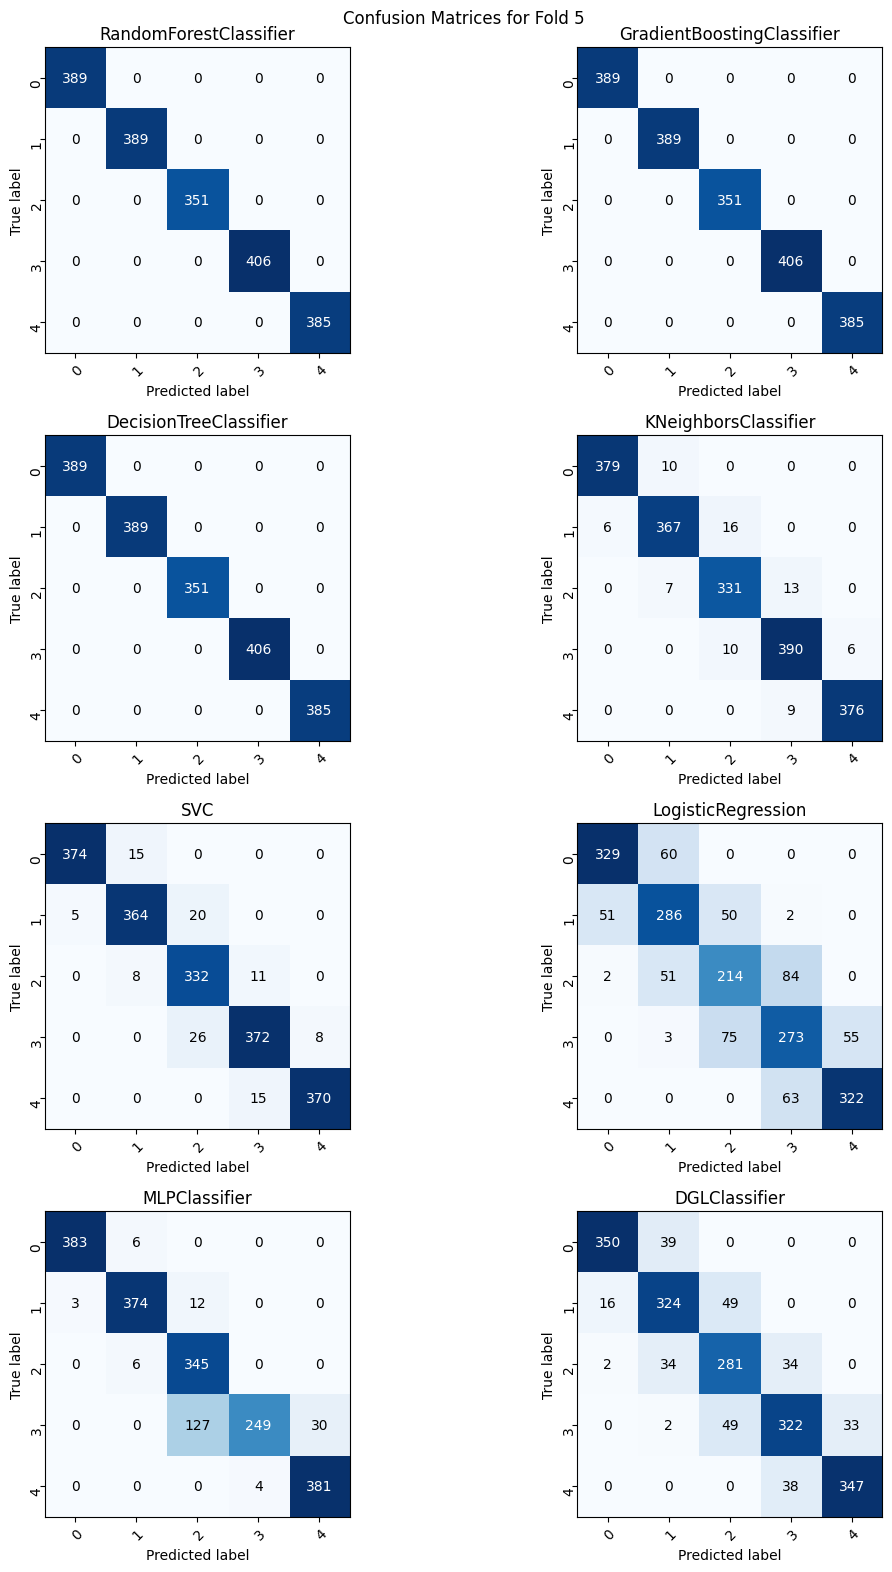

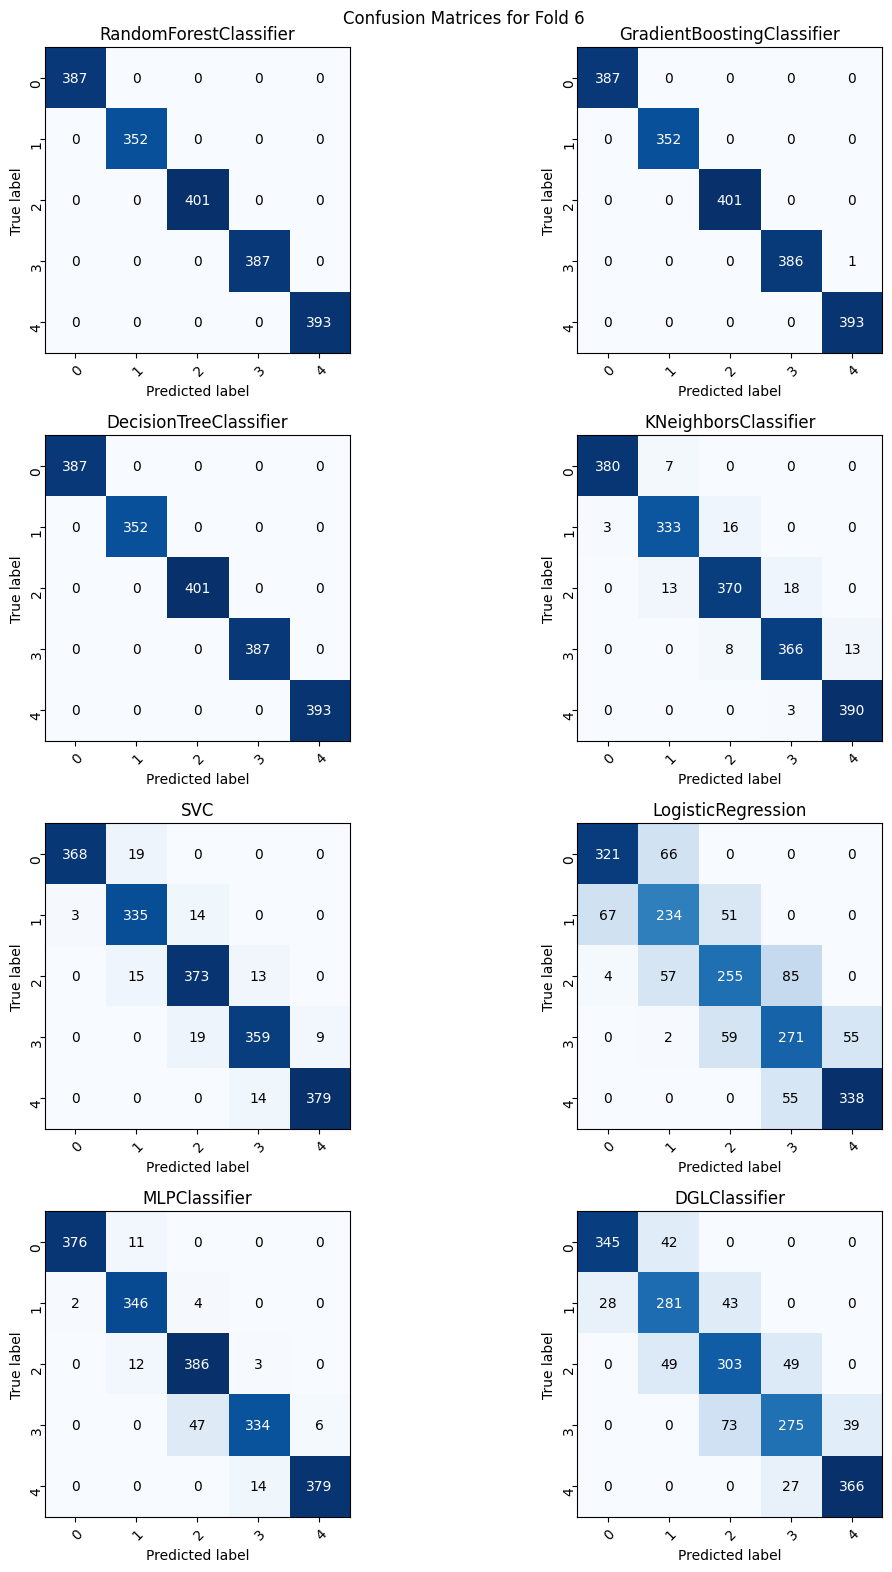

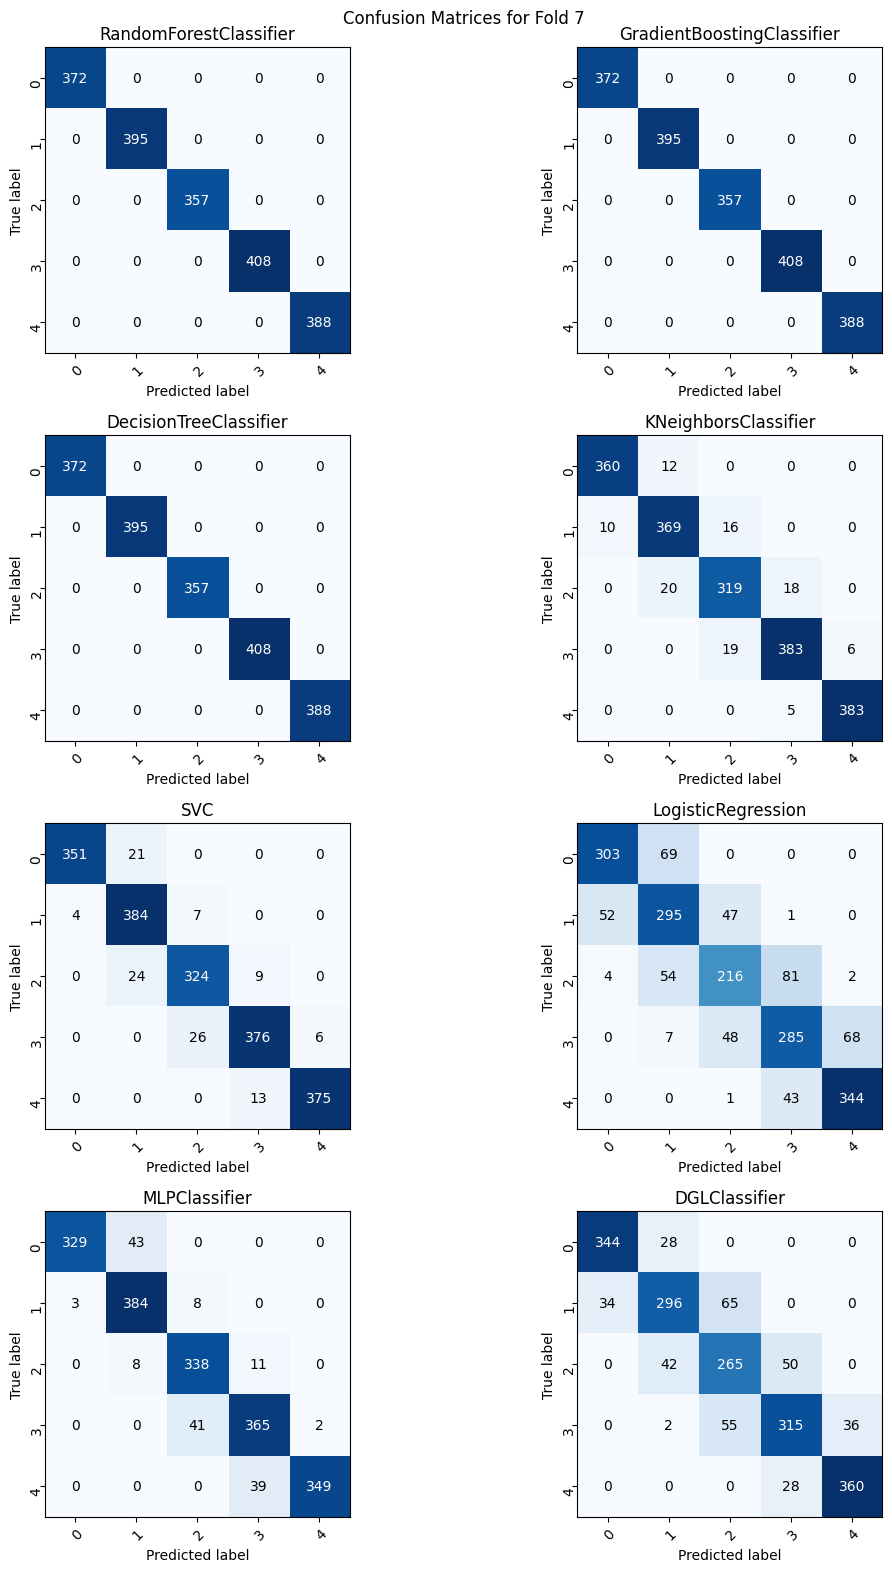

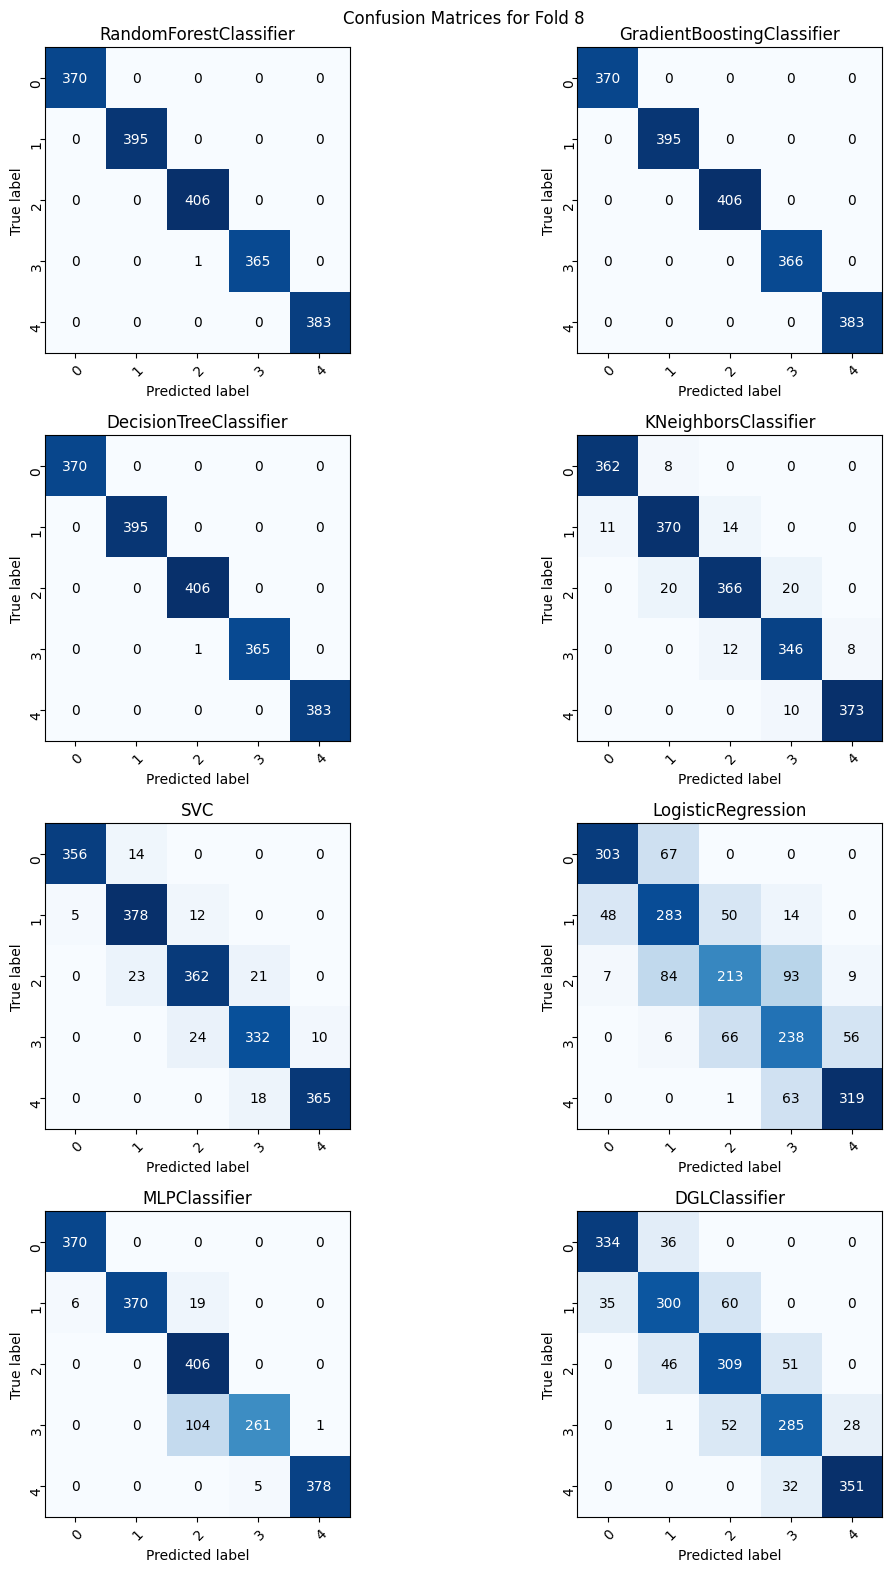

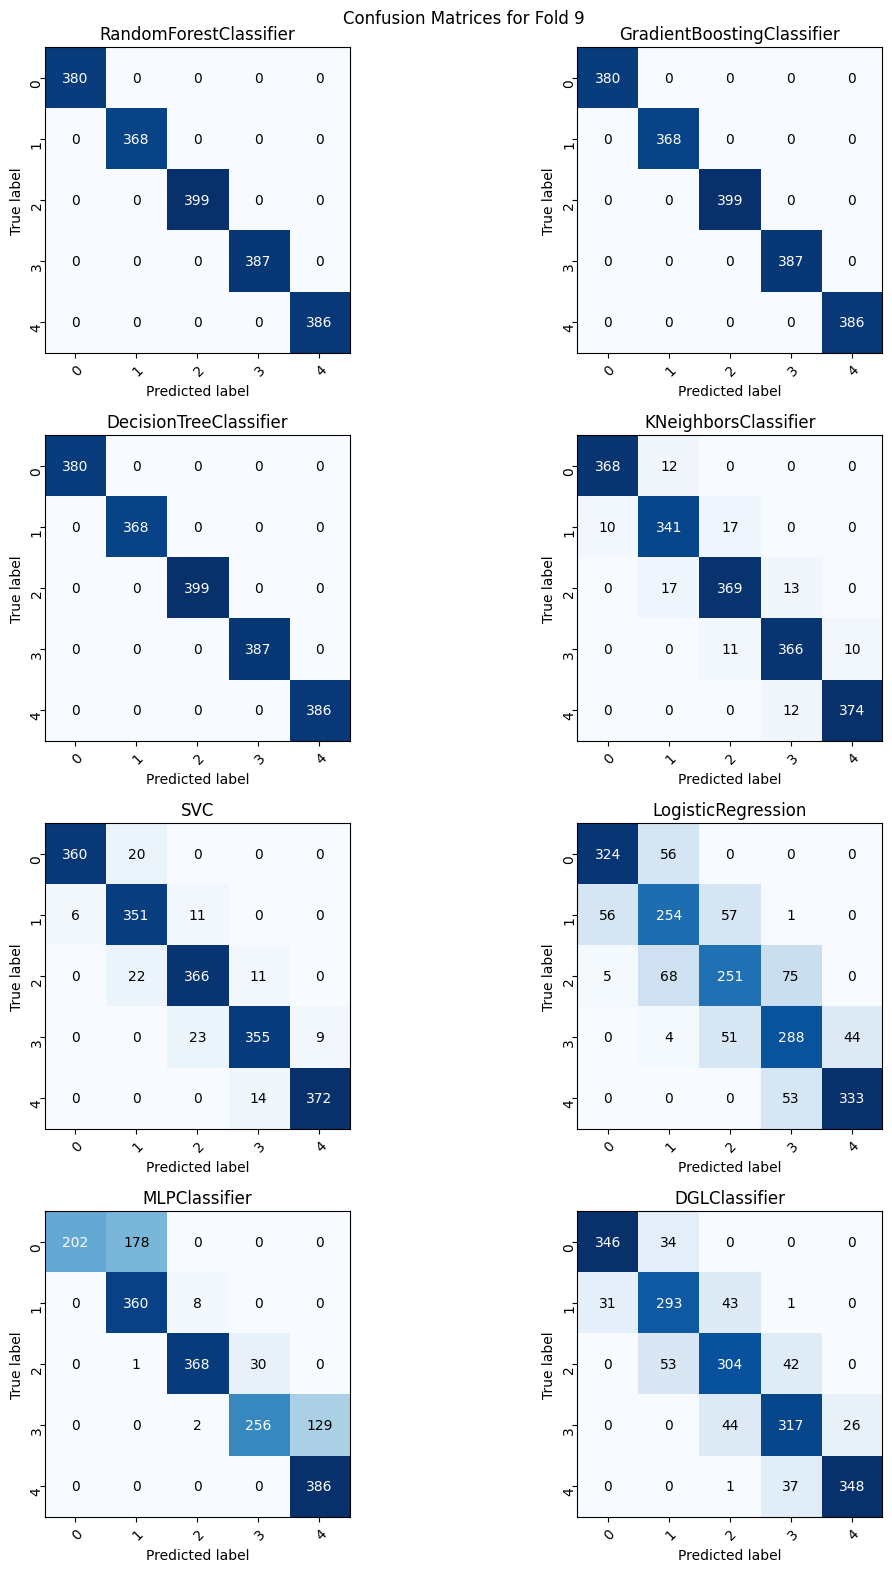

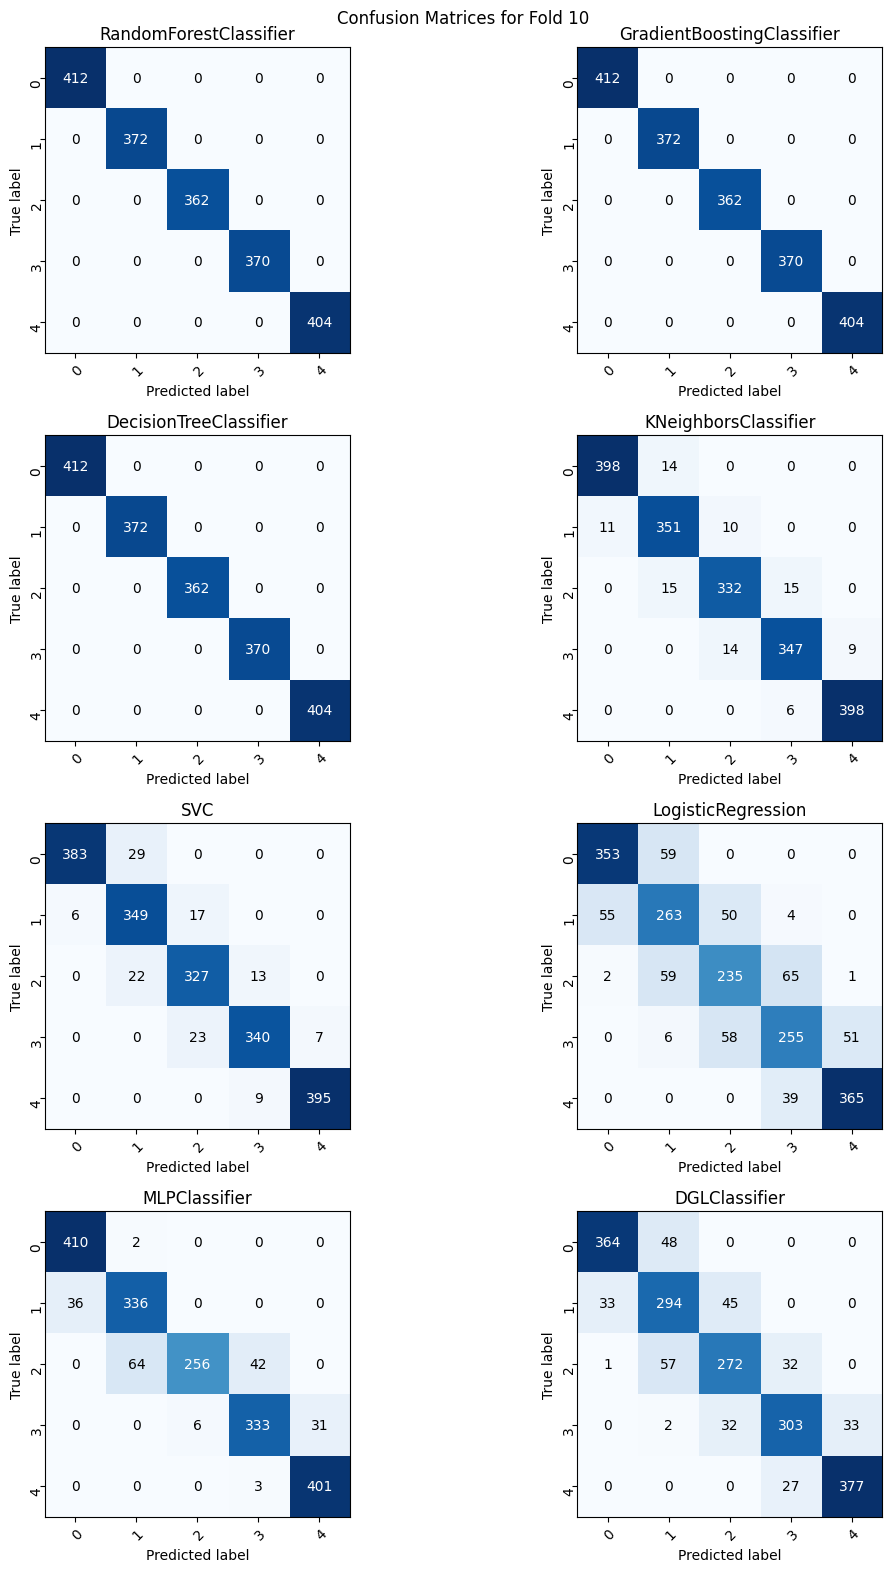

In [ ]:
# Extract fold confusion matrices for each classifier
labels = ['0', '1', '2', '3', '4']
classifiers_cms = {}
for classifier, metrics_list in metrics.items():
    cms_list = metrics_list[1]
    classifiers_cms[classifier] = cms_list

# Iterate over folds, creating a new figure for each one
for fold in range(len(classifiers_cms[list(classifiers_cms.keys())[0]])):
    fig, axs = plt.subplots(4, 2, figsize=(12, 16))

    # Iterate over classifiers, plotting the confusion matrix for this fold in each one
    for i, classifier in enumerate(classifiers):
        row = i // 2
        col = i % 2
        cm = classifiers_cms[type(classifier).__name__][fold]
        axs[row, col].imshow(cm, cmap='Blues')
        axs[row, col].set_title(type(classifier).__name__)
        axs[row, col].set_xlabel('Predicted label')
        axs[row, col].set_ylabel('True label')
        tick_marks = np.arange(len(labels))
        axs[row, col].set_xticks(tick_marks)
        axs[row, col].set_xticklabels(labels)
        axs[row, col].set_yticks(tick_marks)
        axs[row, col].set_yticklabels(labels, rotation=90, ha="right", rotation_mode="anchor")

        # Add value annotations inside the confusion matrix
        for i in range(len(labels)):
            for j in range(len(labels)):
                axs[row, col].text(j, i, str(cm[i, j]), ha='center', va='center',
                                    color='white' if cm[i, j] > cm.max() / 2 else 'black')
                
        plt.setp(axs[row, col].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Set overall figure title and save the figure
    fig.suptitle(f'Confusion Matrices for Fold {fold+1}')
    plt.tight_layout()
    plt.savefig(f'confusion_matrices_fold{fold+1}.png')
    plt.show()
